# Load Data 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline  

import seaborn as sns 
from statsmodels.formula.api import ols

import scipy.stats as stats

import math 


In [2]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Scrub - Converting data types 

In [3]:
#convert column name ['date'] from object to datetime 

#might be cool to create a function that takes any column date and converts it 

df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

In [4]:
# Obvious issue with sqft_basement due to columns
#First attempt to convert failed due to ? marks so we need to remove them 

df['sqft_basement'].nunique() 

304

In [5]:
#replacing all ? with 0's - major assumption that requires data enrichment to correct
#

df['sqft_basement'] = df['sqft_basement'].map(lambda x: 0 if x==
                                             '?' else x)

df['sqft_basement'] = df['sqft_basement'].astype(float)

In [6]:
# Scrub - Treating Null values 

In [7]:
# Identify null values 

df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [8]:
# Look for columns where all 3 are missing 
#This isnt a huge % of the data so we allow it 

print('Number Missing All Three:',
     len(df[(df.waterfront.isnull())
           & (df.view.isnull())
           & (df.yr_renovated.isnull())]))

Number Missing All Three: 2


In [9]:
#Repeat the same process for view which indicates how many times a house has been viewed

#We replaced all views with a median value, its safe to assume houses on the market in these areas are quite popular and viewed 
median = df['view'].median()
df['view'] = df['view'].fillna(value=median)#Waterfront 0 = No waterfront, 1=Waterfront 

#Making all nulls 0 indicating no waterfront 

df['waterfront'].isna().sum()

df['waterfront'] = df['waterfront'].fillna(0)

In [10]:
df['view'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: view, dtype: float64

In [11]:
df['yr_renovated'].isna().sum()

3842

In [12]:
# Assuming renovation nulls are the same as renovation yr_built 

df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [13]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# Major assumptions of scrubbing 

1. Waterfront - nulls = 0 and 1 means on the waterfront, replaced all nulls with 0 

2. Filled view with median value, assuming all houses are viewed or in demand (justification is this is a major area with lots of people moving there) 

3. if there is no yr_renovated, fill with most recent year built 

In [14]:
# Scrubbing - Outliers 

In [15]:
df.duplicated(subset='id')

0        False
1        False
2        False
3        False
4        False
         ...  
21592    False
21593    False
21594    False
21595    False
21596    False
Length: 21597, dtype: bool

In [16]:
dupe_count = (len(df['id'])) - (len(df['id'].unique()))

In [17]:
dupe_count

177

In [18]:
#dropped all duplicates for id 
#inplace = True changes the dataframe permanently

df.drop_duplicates(subset=['id'], inplace=True)

In [19]:
21597 - 21420 #we lost 177 columns

177

In [20]:
21597 - 21420 #we lost 177 columns

177

# Defining categorical variables

In [21]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.142000e+04,2.142000e+04,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.00000,21420.000000,21420.000000,21420.000000,21420.000000
mean,4.580940e+09,5.407393e+05,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,0.006816,0.233987,3.410784,7.662792,1791.170215,285.904342,1971.092997,418.918534,98077.87437,47.560197,-122.213784,1988.384080,12775.718161
std,2.876761e+09,3.679311e+05,0.925405,0.768720,918.808412,4.153080e+04,0.540081,0.082280,0.765437,0.650035,1.171971,828.692965,440.008202,29.387141,807.450271,53.47748,0.138589,0.140791,685.537057,27345.621867
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.00000,47.155900,-122.519000,399.000000,651.000000
25%,2.123537e+09,3.225000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98033.00000,47.471200,-122.328000,1490.000000,5100.000000
50%,3.904921e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.00000,47.572100,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,550.000000,1997.000000,0.000000,98117.00000,47.678100,-122.125000,2370.000000,10086.250000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.00000,47.777600,-121.315000,6210.000000,871200.000000


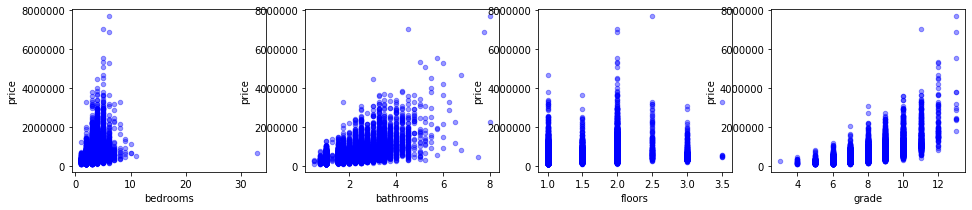

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'floors', 'grade'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

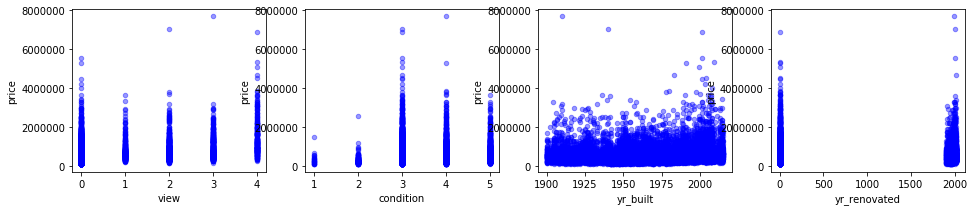

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['view', 'condition', 'yr_built', 'yr_renovated'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

# Transforming categorical variables 

# Potentially encode 'floors', 'grade', 'view', 'condition', 'yr_renovated'

# Multicollinearity 

In [24]:
abs(df.corr()) > 0.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [25]:
import plotly.express as px
import plotly.graph_objects as go


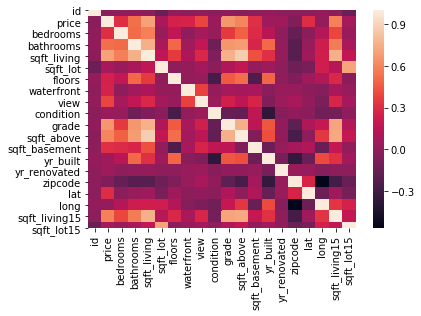

In [26]:
corr = df.corr()

sns.heatmap(corr)

# sqft_living is multicolinear with the most columns (5) then grade (3)

# yr_built, yr_renovated are mc so one needs to go 

# sqft_above needs to be dropped 

# Tranforming Categorical Variables 

In [27]:
df[['floors', 'grade', 'view', 'condition']].nunique()

floors        6
grade        11
view          5
condition     5
dtype: int64

# Label Encoder 

In [28]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()

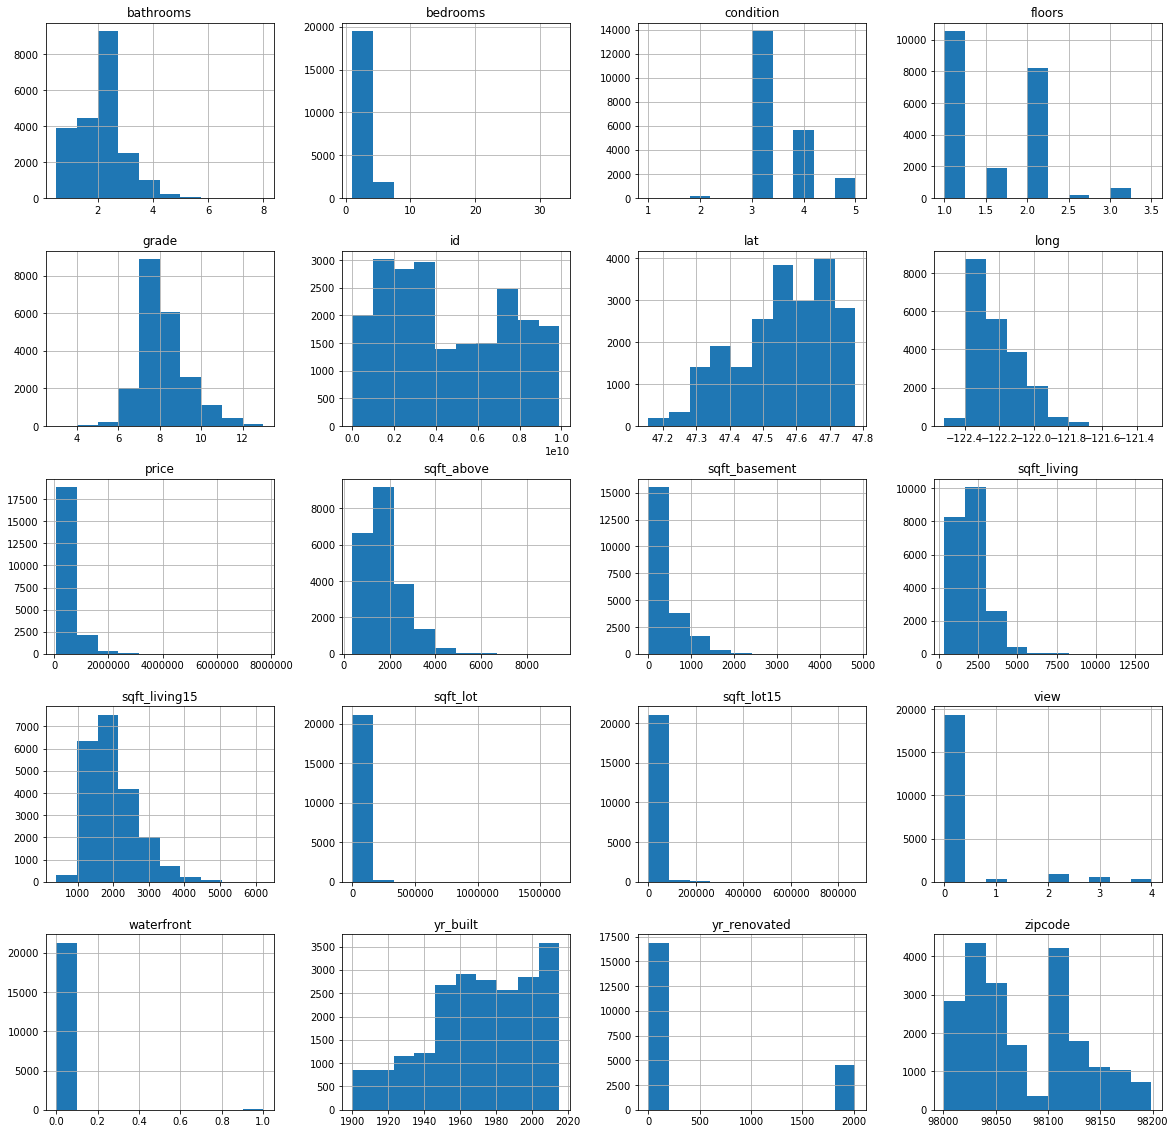

In [29]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
df.hist(ax = ax);

# Drop Outliers from Sqft variables

In [30]:
#sqft_living 

indexNames = df[df['sqft_living'] >= 5000 ].index
df.drop(indexNames , inplace=True)


In [31]:
# sqft_above 

indexNames = df[df['sqft_living'] >= 4500 ].index
df.drop(indexNames , inplace=True)


In [32]:
#sqft_basement 

indexNames = df[df['sqft_basement'] >= 2000 ].index
df.drop(indexNames , inplace=True)

In [33]:
# dropping sqft_living15 outliers
indexNames = df[df['sqft_living'] >= 4500 ].index
df.drop(indexNames , inplace=True)


In [34]:
# dropping sqft_lot outliers
indexNames = df[df['sqft_lot'] >= 100000 ].index
df.drop(indexNames , inplace=True)


In [35]:

# dropping sqft_lot15 outliers
indexNames = df[df['sqft_lot15'] >= 100000 ].index
df.drop(indexNames , inplace=True)


# Check the assumptions

# Linear Relationship

Graph all the explanatory variables against the outcome 



# Checking sqft variables

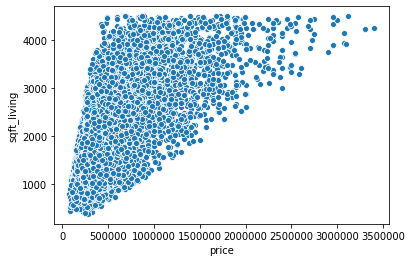

In [86]:
sns.scatterplot(x='price', y='sqft_living', data=df)

Observation: There is correlation but outliers are worth noting. Heteroscedacity possible.

(array([ 393., 2531., 4342., 4239., 3514., 2360., 1509.,  863.,  507.,
         279.]),
 array([ 370. ,  782.5, 1195. , 1607.5, 2020. , 2432.5, 2845. , 3257.5,
        3670. , 4082.5, 4495. ]),
 <a list of 10 Patch objects>)

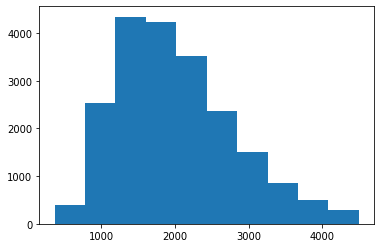

In [87]:
# Histogram of variable 

plt.hist(df['sqft_living'])

# With log function

(array([  11.,   40.,  342., 1052., 2402., 3958., 4751., 4232., 2693.,
        1056.]),
 array([5.91350301, 6.1632248 , 6.41294659, 6.66266839, 6.91239018,
        7.16211198, 7.41183377, 7.66155556, 7.91127736, 8.16099915,
        8.41072095]),
 <a list of 10 Patch objects>)

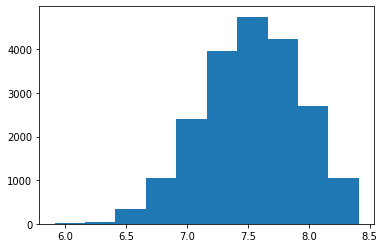

In [88]:
df['sqft_living_log'] = np.log(df['sqft_living'])
plt.hist(df['sqft_living_log'])

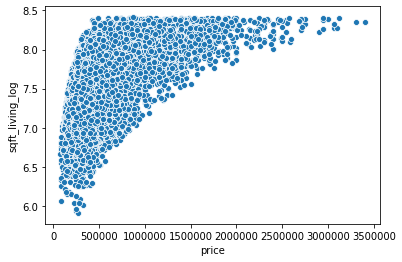

In [89]:
sns.scatterplot(x='price', y='sqft_living_log', data=df)

(array([  11.,   40.,  342., 1052., 2402., 3958., 4751., 4232., 2693.,
        1056.]),
 array([5.91350301, 6.1632248 , 6.41294659, 6.66266839, 6.91239018,
        7.16211198, 7.41183377, 7.66155556, 7.91127736, 8.16099915,
        8.41072095]),
 <a list of 10 Patch objects>)

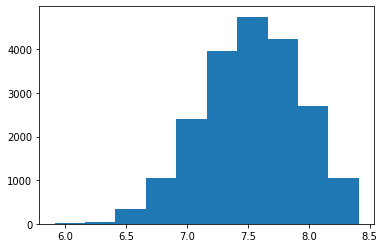

In [90]:
plt.hist(df['sqft_living_log'])

Created a normal distribution of this variable

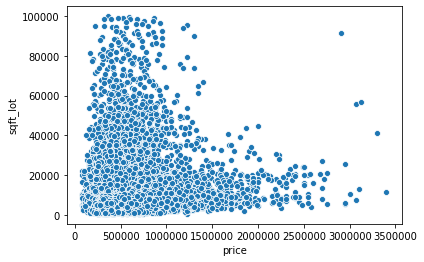

In [91]:
sns.scatterplot(x='price', y='sqft_lot', data=df)

# Log function

(array([  88.,  773.,  635., 2155., 5936., 7443., 1940.,  655.,  699.,
         213.]),
 array([ 6.25382881,  6.77965444,  7.30548007,  7.8313057 ,  8.35713133,
         8.88295696,  9.40878259,  9.93460822, 10.46043385, 10.98625948,
        11.51208511]),
 <a list of 10 Patch objects>)

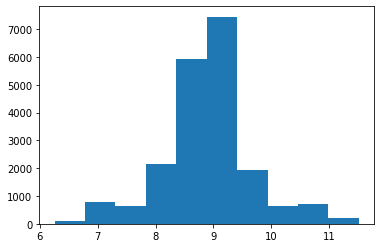

In [92]:
df['sqft_lot_log'] = np.log(df['sqft_lot'])

plt.hist(df['sqft_lot_log'])

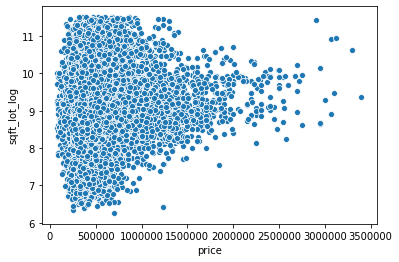

In [93]:
sns.scatterplot(x='price', y='sqft_lot_log', data=df)

(array([  88.,  773.,  635., 2155., 5936., 7443., 1940.,  655.,  699.,
         213.]),
 array([ 6.25382881,  6.77965444,  7.30548007,  7.8313057 ,  8.35713133,
         8.88295696,  9.40878259,  9.93460822, 10.46043385, 10.98625948,
        11.51208511]),
 <a list of 10 Patch objects>)

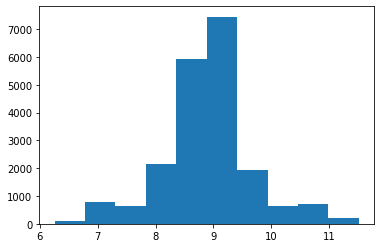

In [94]:
plt.hist(df['sqft_lot_log'])

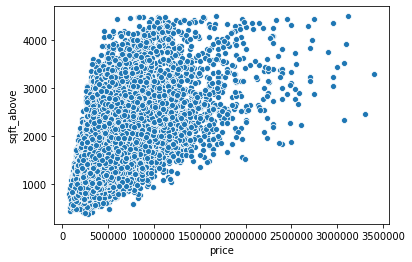

In [95]:
sns.scatterplot(x='price', y='sqft_above', data=df)

(array([  11.,   68.,  546., 1910., 4213., 4844., 3682., 2883., 1812.,
         568.]),
 array([5.91350301, 6.1631135 , 6.412724  , 6.6623345 , 6.911945  ,
        7.16155549, 7.41116599, 7.66077649, 7.91038699, 8.15999748,
        8.40960798]),
 <a list of 10 Patch objects>)

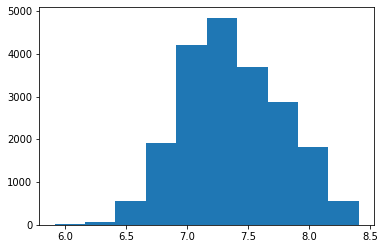

In [96]:
df['sqft_above_log'] = np.log(df['sqft_above'])


plt.hist(df['sqft_above_log'])

Observation: Heteroscedacity is appearing 

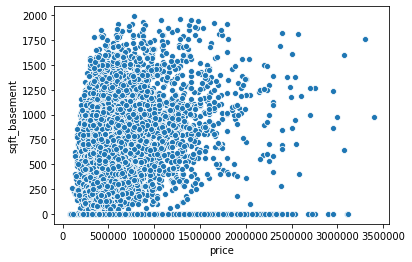

In [97]:
sns.scatterplot(x='price', y='sqft_basement', data=df)

Observation: Heteroscedacity is appearing again!

# Log Function

In [98]:
df['sqft_basement_log'] = np.log(df['sqft_basement'])

sns.scatterplot(x='price', y='sqft_living15', data=df)

In [99]:
# Log function

In [100]:
df['sqft_living15_log'] = np.log(df['sqft_living15'])

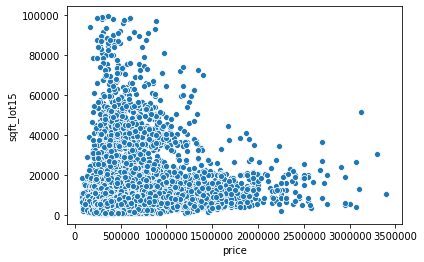

In [101]:
sns.scatterplot(x='price', y='sqft_lot15', data=df)

Observation: Lots of heteroscedacity 

# sqft columns all have heteroscedacity
# Log function is being applied to all sqft columns

In [46]:
# Since multicolinearity is displayed, certain columns will need to be removed

#Before I make that decision, 

# Linear Relationship with the rest of the variables 

In [47]:
'bedrooms', 'bathrooms', 'yr_built', 'yr_renovated', 'grade'

('bedrooms', 'bathrooms', 'yr_built', 'yr_renovated', 'grade')

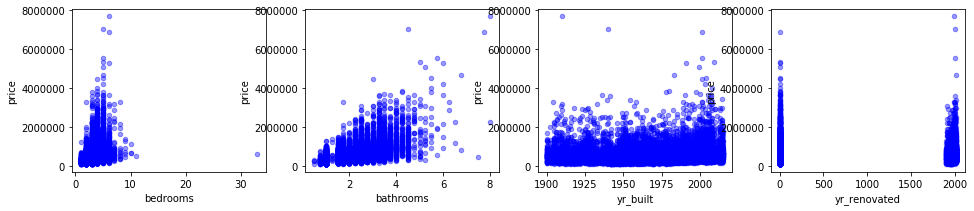

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'yr_built', 'yr_renovated', 'grade'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

# Feature Scaling and Normalization

## We have already scaled all sqft variables with log 

### Variables left to investigate: 
    

In [64]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_living_log',
       'sqft_lot_log', 'sqft_basement_log', 'sqft_living15_log',
       'sqft_above_log'],
      dtype='object')

In [ ]:
'bedrooms', 'bathrooms','floors', 'waterfront', 'view', 'condition', 'grade'

In [ ]:
sqft_log = df[ 'sqft_living_log',
       'sqft_lot_log', 'sqft_basement_log', 'sqft_living15_log',
       'sqft_above_log']

# Lets go ahead and drop outliers from the categorical variables 

In [103]:
cats = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade','zipcode']
for cat in cats:
    print(df[cat].value_counts(normalize=False))


3     9453
4     6525
2     2675
5     1428
6      225
1      185
7       27
8       10
9        5
10       2
11       1
33       1
Name: bedrooms, dtype: int64
2.50    5200
1.00    3739
1.75    2949
2.25    1983
2.00    1864
1.50    1405
2.75    1141
3.00     702
3.50     635
3.25     513
3.75     124
4.00      87
0.75      69
4.50      59
4.25      34
1.25       9
5.00       8
4.75       5
0.50       4
5.25       4
7.50       1
6.00       1
5.75       1
Name: bathrooms, dtype: int64
1.0    10270
2.0     7723
1.5     1810
3.0      597
2.5      131
3.5        6
Name: floors, dtype: int64
0.0    20422
1.0      115
Name: waterfront, dtype: int64
0.0    18703
2.0      849
3.0      422
1.0      308
4.0      255
Name: view, dtype: int64
3    13287
4     5447
5     1630
2      146
1       27
Name: condition, dtype: int64
7     8736
8     5909
9     2459
6     1956
10     968
11     234
5      223
4       27
12      24
3        1
Name: grade, dtype: int64
98103    600
98115    575
98052    56

In [106]:
# dropping grade outliers
indexNames = df[df['grade'] == 3 ].index
df.drop(indexNames , inplace=True)
indexNames = df[df['grade'] == 13 ].index
df.drop(indexNames , inplace=True)

In [107]:
# dropping bedroom outliers over 8 rooms
indexNames = df[df['bedrooms'] >= 8 ].index
df.drop(indexNames , inplace=True)

In [ ]:
#Floors - we need to group them 

(array([1.0265e+04, 0.0000e+00, 1.8090e+03, 0.0000e+00, 7.7100e+03,
        0.0000e+00, 1.3000e+02, 0.0000e+00, 5.9700e+02, 6.0000e+00]),
 array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ]),
 <a list of 10 Patch objects>)

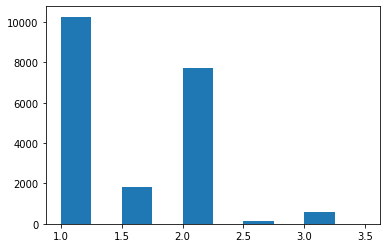

In [108]:
plt.hist(df['floors'])

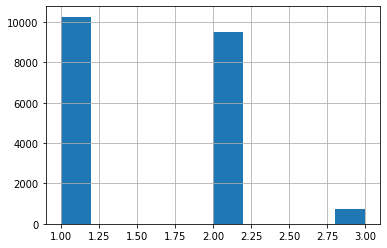

In [117]:
#grouping floors
new_floor = []

for i in df.floors:
    new_floor.append(math.ceil(i))
df.floors = new_floor

#now to group the outliers into the largest category
def group_floors(value):
    if value > 3:
        return 3
    else:
        return value


df.floors = df.floors.map(lambda x: group_floors(x))
df.floors.hist();


In [ ]:
# Bathrooms 

(array([3.811e+03, 1.414e+03, 4.811e+03, 7.182e+03, 1.835e+03, 1.146e+03,
        2.100e+02, 9.100e+01, 1.200e+01, 5.000e+00]),
 array([0.5  , 1.025, 1.55 , 2.075, 2.6  , 3.125, 3.65 , 4.175, 4.7  ,
        5.225, 5.75 ]),
 <a list of 10 Patch objects>)

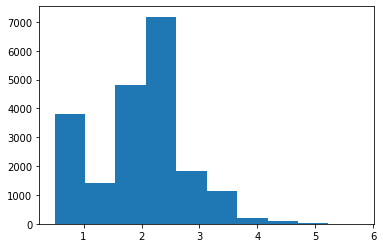

In [119]:
plt.hist(df['bathrooms'])

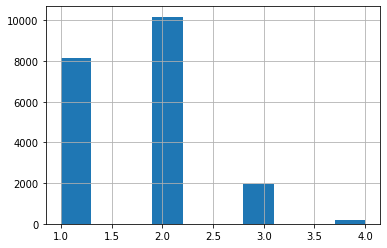

In [120]:
#grouping bathrooms
new_bath = []
for i in df.bathrooms:
    if i >= 1:
        new_bath.append(math.trunc(i))
    else:
        new_bath.append(1)    
df.bathrooms = new_bath

#now to group the outliers into the largest category
def impute_baths(value):
    if value > 4:
        return 4
    else:
        return value


df.bathrooms = df.bathrooms.map(lambda x: impute_baths(x))
df.bathrooms.hist();

# Dropping price outliers 
## Dropped everything over a million usd 

(array([8.953e+03, 8.329e+03, 2.291e+03, 5.600e+02, 2.100e+02, 9.600e+01,
        4.500e+01, 2.000e+01, 7.000e+00, 6.000e+00]),
 array([  78000.,  410200.,  742400., 1074600., 1406800., 1739000.,
        2071200., 2403400., 2735600., 3067800., 3400000.]),
 <a list of 10 Patch objects>)

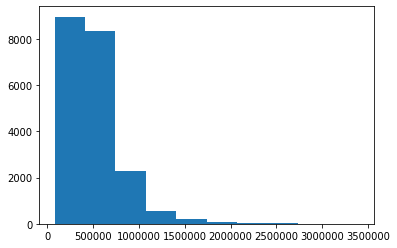

In [122]:
plt.hist(df['price'])

In [123]:
indexNames =  df[df['price'] >= 1000000].index
df.drop(indexNames, inplace=True)

(array([ 368., 2433., 3950., 3577., 2870., 2281., 1529., 1153.,  741.,
         475.]),
 array([ 78000. , 170199.9, 262399.8, 354599.7, 446799.6, 538999.5,
        631199.4, 723399.3, 815599.2, 907799.1, 999999. ]),
 <a list of 10 Patch objects>)

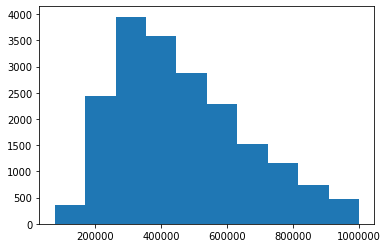

In [124]:
plt.hist(df['price'])

# Exploratory Data Analysis 

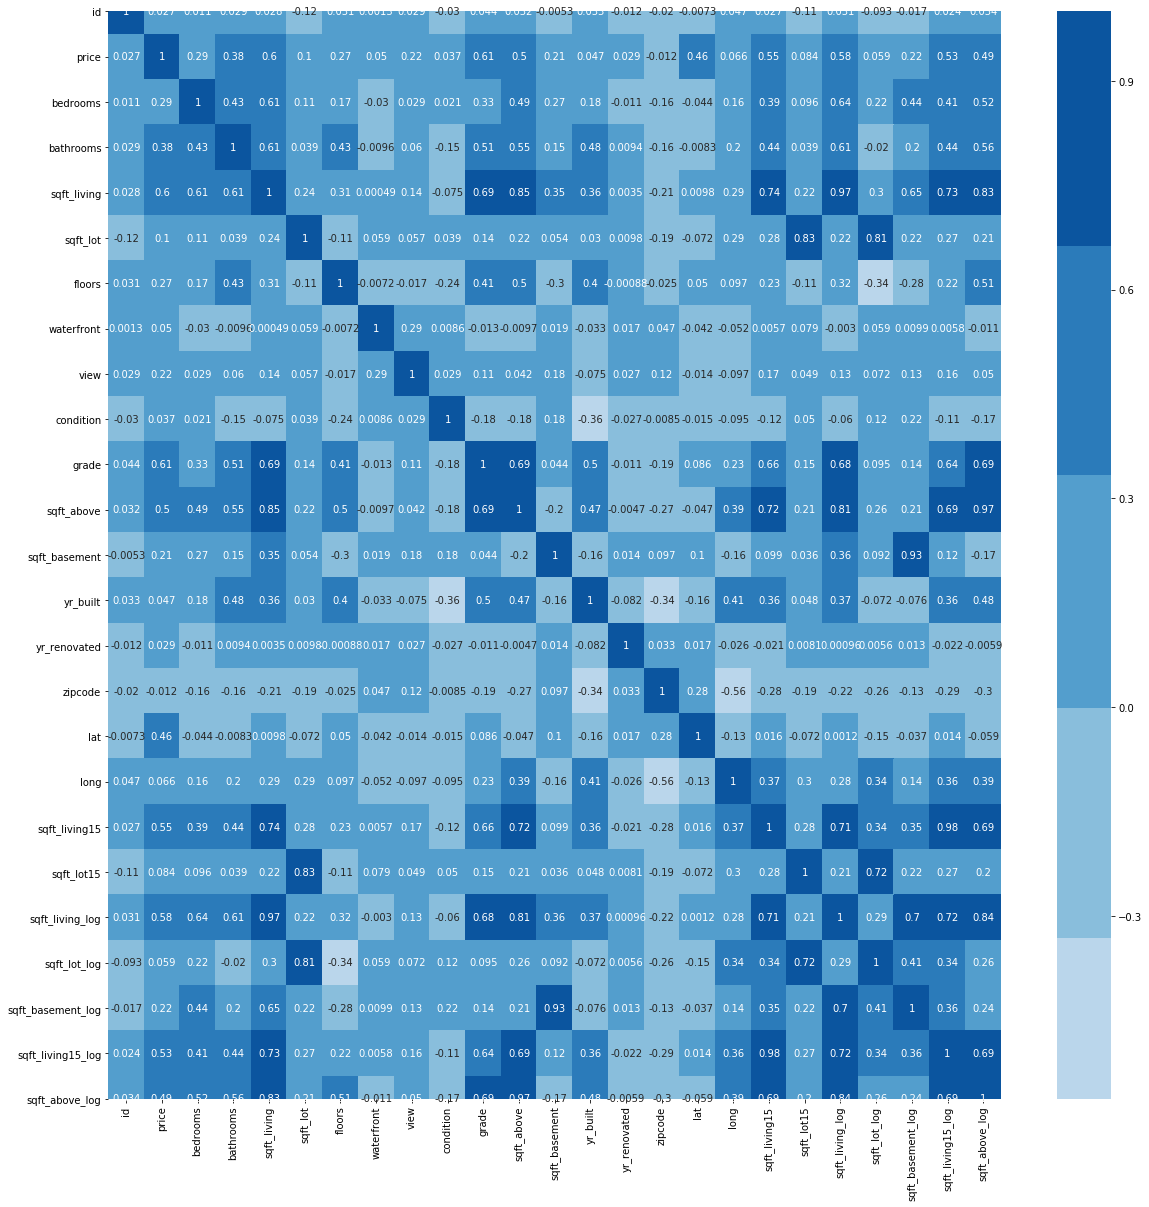

In [128]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, cmap=sns.color_palette('Blues'), center=0)

In [140]:
df.drop(columns=['sqft_living','sqft_basement', 'sqft_living15','sqft_above', 'lat', 'long'], axis=1, inplace=True)

KeyError: "['sqft_living' 'sqft_basement' 'sqft_living15' 'sqft_above'] not found in axis"

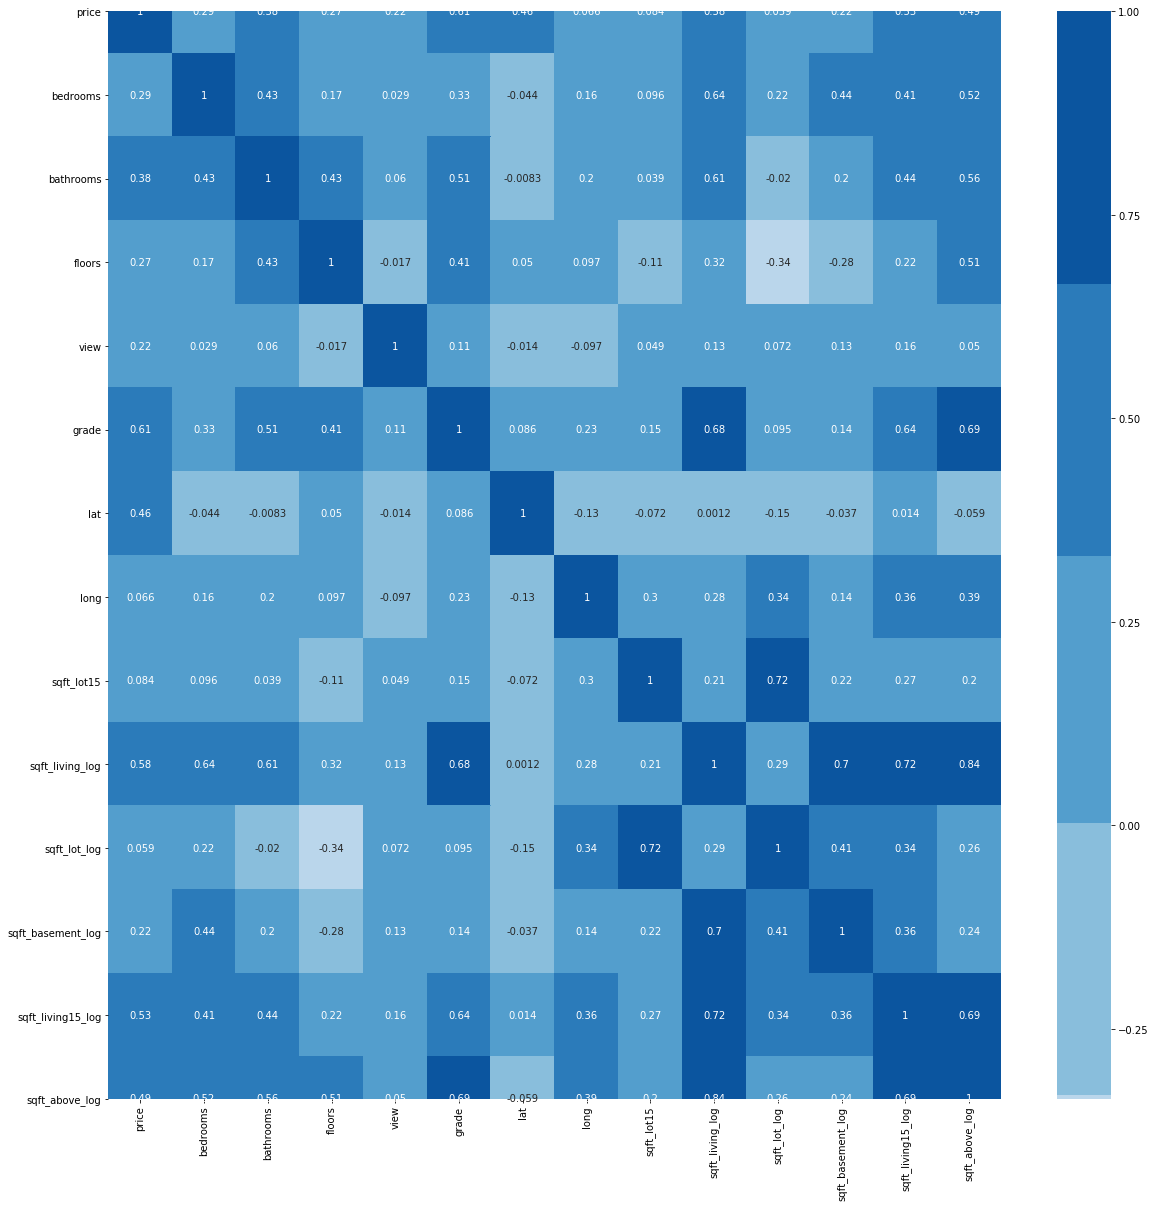

In [138]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, cmap=sns.color_palette('Blues'), center=0)

In [141]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'floors', 'view', 'grade',
       'lat', 'long', 'sqft_lot15', 'sqft_living_log', 'sqft_lot_log',
       'sqft_basement_log', 'sqft_living15_log', 'sqft_above_log'],
      dtype='object')

In [143]:
df.drop(columns = ['date', 'lat', 'long', 'sqft_lot15'], axis=1, inplace=True)

In [144]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'view', 'grade',
       'sqft_living_log', 'sqft_lot_log', 'sqft_basement_log',
       'sqft_living15_log', 'sqft_above_log'],
      dtype='object')

In [178]:
outcome = 'price'
x_cols = ['bedrooms', 'bathrooms', 'floors', 'view', 'grade',
       'sqft_living_log', 'sqft_lot_log', 'sqft_basement_log',
       'sqft_living15_log', 'sqft_above_log']


In [179]:
df.columns = [col.replace(' ', '_') for col in df.columns]

for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()

    df.head()

In [180]:
from statsmodels.formula.api import ols

In [181]:
# Fitting the actual model
    predictors = '+'.join(x_cols)
    formula = outcome + '~' + predictors
    model = ols(formula=formula, data=df).fit()
    model.summary()

ValueError: zero-size array to reduction operation maximum which has no identity

In [168]:
# Drop ID and date 
features= list(df.columns.drop(['id', 'date', 'lat', 'long']))

KeyError: "['id' 'date' 'lat' 'long'] not found in axis"

In [ ]:
#find things 3 stdev above the need 

from scipy import stats
df[(np.abs(stats.zscore(df[features])) < 3).all(axis=1)]

In [ ]:
new_df = df[(np.abs(stats.zscore(df[features])) < 3).all(axis=1)]